## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Make sure to change path if you put the zip elsewhere
!unzip drive/MyDrive/Colab\ Notebooks/chest_xray.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: chest_xray/train/pneumonia/person1608_bacteria_4235.jpeg  
  inflating: chest_xray/train/pneumonia/person445_virus_916.jpeg  
  inflating: chest_xray/train/pneumonia/person302_bacteria_1430.jpeg  
  inflating: chest_xray/train/pneumonia/person1188_bacteria_3137.jpeg  
  inflating: chest_xray/train/pneumonia/person353_virus_728.jpeg  
  inflating: chest_xray/train/pneumonia/person348_bacteria_1602.jpeg  
  inflating: chest_xray/train/pneumonia/person1272_bacteria_3232.jpeg  
  inflating: chest_xray/train/pneumonia/person1294_virus_2222.jpeg  
  inflating: chest_xray/train/pneumonia/person3_bacteria_12.jpeg  
  inflating: chest_xray/train/pneumonia/person124_virus_234.jpeg  
  inflating: chest_xray/train/pneumonia/person378_virus_761.jpeg  
  inflating: chest_xray/train/pneumonia/person1478_bacteria_3848.jpeg  
  inflating: chest_xray/train/pneumonia/person1446_bacteria_3740.jpeg  
  inflating: che

## Create dataset from directory

In [4]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


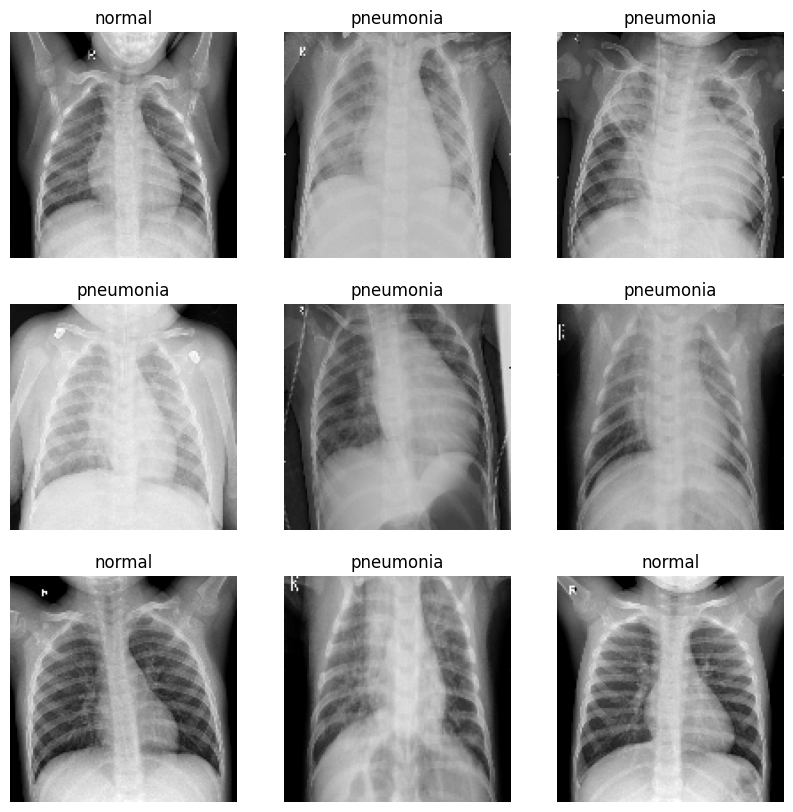

In [5]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [6]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

In [7]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

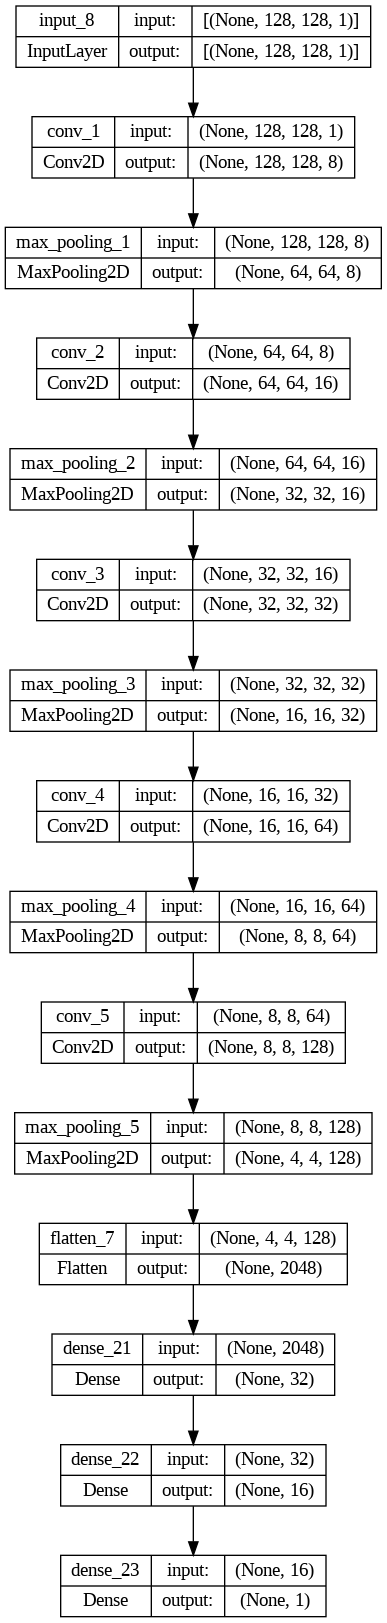

In [70]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)
import keras
from scipy import signal
from scipy import datasets

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.

#model = keras.Sequential()
x = (layers.Conv2D(8,3,padding="same", activation='relu',input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))(input)
x = (layers.MaxPooling2D(pool_size=(2,2),padding="same"))(x)
x = (layers.Conv2D(16, 3,padding="same", activation='relu'))(x)
x = (layers.MaxPooling2D(pool_size=(2,2),padding="same"))(x)
x = (layers.Conv2D(32, 3, padding="same",activation='relu'))(x)
x = (layers.MaxPooling2D(pool_size=(2,2),padding="same"))(x)
x = (layers.Conv2D(64, 3,padding="same", activation='relu'))(x)
x = (layers.MaxPooling2D(pool_size=(2,2),padding="same"))(x)
x = (layers.Conv2D(128, 3,padding="same", activation='relu'))(x)
x = (layers.MaxPooling2D(pool_size=(2,2),padding="same"))(x)

x = (layers.Flatten())(x)
x = (layers.Dense(32, activation='softmax'))(x)
x = (layers.Dense(16, activation='softmax'))(x)

cnn_output = layers.Dense(1, activation='sigmoid')(x)
cnn = Model(inputs=input, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

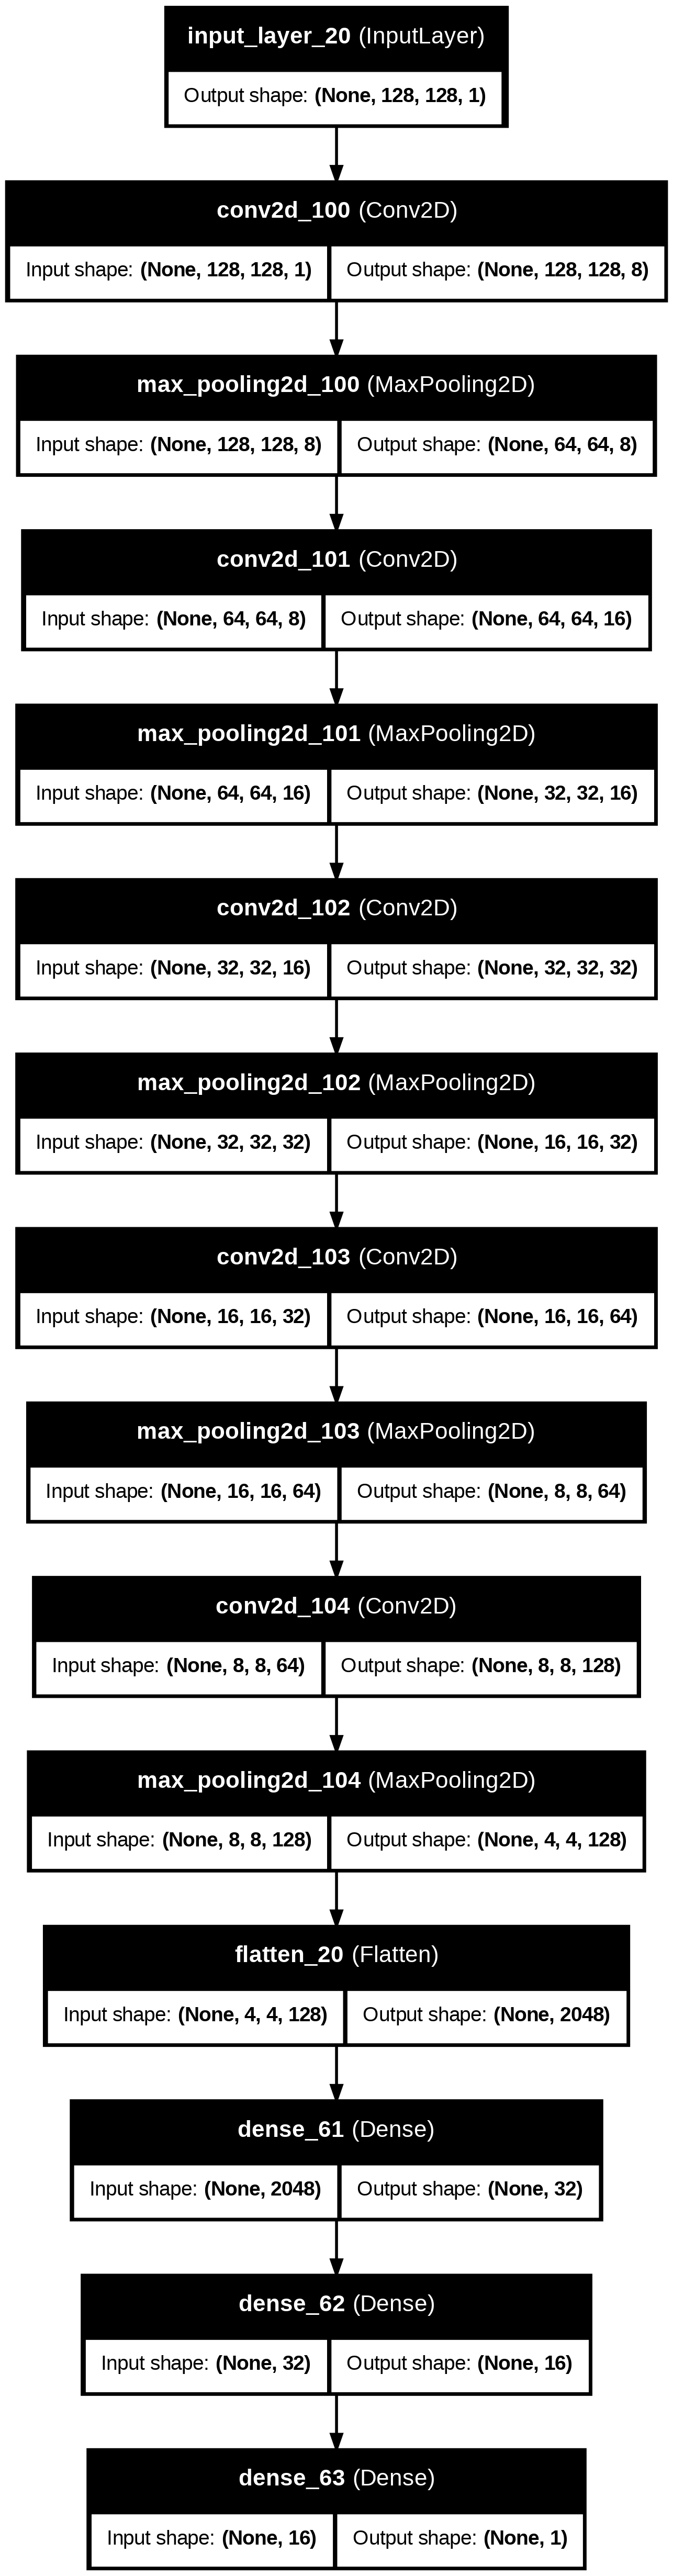

In [71]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [63]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights
)

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5795 - loss: 0.6845 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4694 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4488 - loss: 0.6863 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 995ms/step - accuracy: 0.3753 - loss: 0.6911 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4430 - loss: 0.6847 - val_accuracy: 0.5000 - val_loss: 0.6931


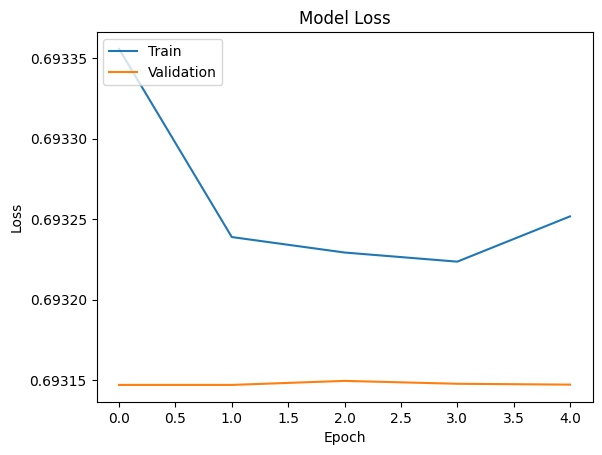

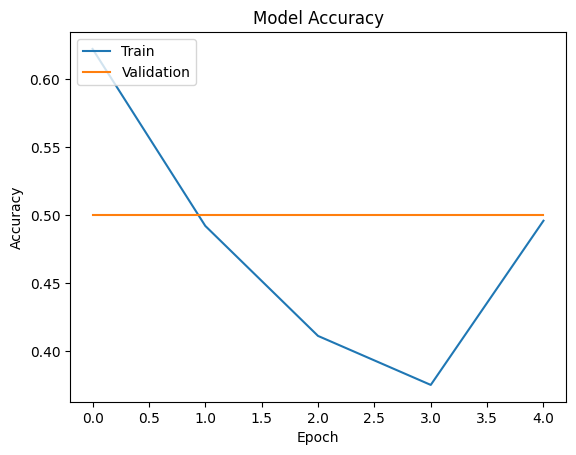

In [64]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


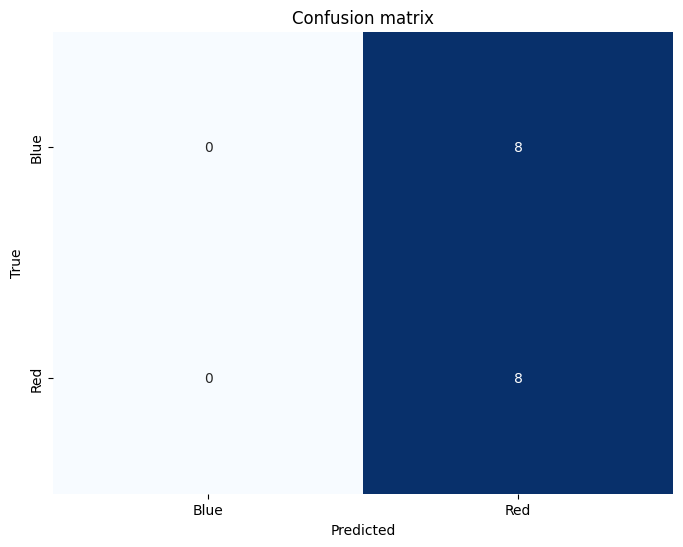

Mean F1 Score across all folds: 0.6666666666666666


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from sklearn.model_selection import KFold
val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here
# and do the same for test set
def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Blue", "Red"], yticklabels=["Blue", "Red"])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

f1_scores = []
mean_confusion_matrix = np.zeros((2, 2))

predictions = (cnn.predict(val_images) > 0).astype(int)
# Compute confusion matrix
cm = confusion_matrix(val_labels, predictions)
mean_confusion_matrix += confusion_matrix(val_labels, predictions)
# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Confusion matrix')

# Calculate and display the mean F1 score across all folds
# Compute F1 score
f1 = f1_score(val_labels, predictions)
print(f"Mean F1 Score across all folds: {f1}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step


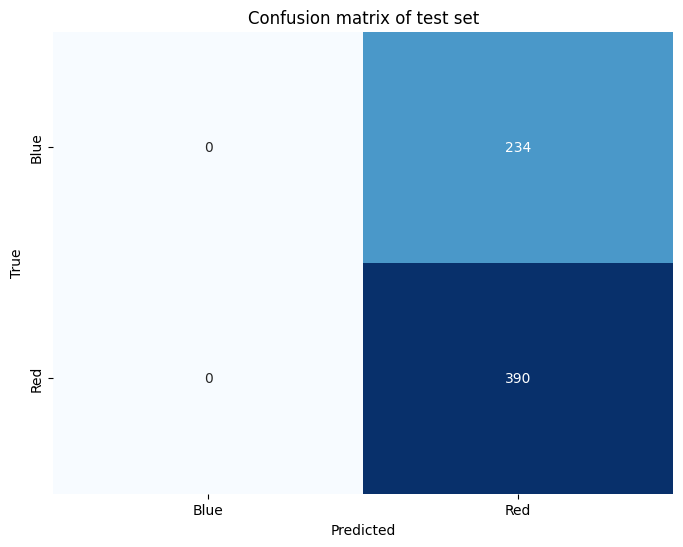

Mean F1 Score with test set: 0.7692307692307693


In [77]:
test_images = []
test_labels = []

for img, label in test_ds:
  test_images.append(img)
  test_labels.append(label)

test_images = np.vstack(test_images)
test_labels = np.vstack(test_labels).squeeze().astype(int)

f1_scores = []
mean_confusion_matrix = np.zeros((2, 2))

predictions = (cnn.predict(test_images) > 0).astype(int)
# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions)
mean_confusion_matrix += confusion_matrix(test_labels, predictions)
# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Confusion matrix of test set')

# Calculate and display the mean F1 score across all folds
# Compute F1 score
f1 = f1_score(test_labels, predictions)
print(f"Mean F1 Score with test set: {f1}")